In [1]:
import numpy as np
import torch


In [2]:
with open('data/names.txt', 'r') as f:
    data = f.read().splitlines()


In [3]:
chars = sorted(set(''.join([d for d in data])))
chars = ['.'] + chars
ctoi = {c:i for i, c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}

print(ctoi)
print(itoc)
X = []
block_size = 2 # Tri-gram
for word in data:
    context = [0] * block_size
    for c in word + '.':
        ix = ctoi[c]
        X.append(context + [ix])
        context = context[1:] + [ix]

print(len(X))

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
228146


## Counting the occurence and then predicting 

In [4]:
# First let's 'train' a simple 'network': Count how many times one character follows another and
# use that to sample next word to generate word. NOT using a Neural Network


counts = torch.zeros(27, 27, 27)
# print(counts.size())
# counts[0, 0, 0] represents count of '...' sequence in our training data, counts[0, 1, 0] represents count of '.a.' in our training data and so on
for val in X:
    counts[val[0], val[1], val[2]] += 1


print(counts[0, 0, :])
# Now Normalize
# '...', '..a', '..b', '..c', '..d', ..... and so on should sum to 1.0 (i.e., normalize across count[0, 0, i])
# '.a.', '.aa', '.ab', '.ac', '.ad', ... and so on should sum to 1.0 (i.e., across count[0, 1, i])
# '.b.', '.ba', '.bb', '.bc', '.bd', ... and so on should sum to 1.0 (i.e., across count[0, 2, i])
# ...
# 'z..', 'z.a', 'z.b', 'z.c', 'z.d', ...
# ...
# 'zz.', 'zza', 'zzb', 'zzc', 'zzd', ...

# i.e., for every previous occurrences, we have to sum along dimension = 2 (position of i above)

counts = counts + 1 # Avoid division by zero (smoothing) as this 1 increase to higher number, we get uniform distribution. Hence smoothing.
counts = counts / counts.sum(dim=2, keepdim=True)

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])


In [5]:
# Check if it sums to 1.0
print(sum(counts[0, 0, :]))
print(sum(counts[0, 1, :]))
print(sum(counts[0, 1, :]))

# Rough code to see dimension
# ten = torch.tensor([[[1,2,3],[1,2,3],[1,2,3]], [[10,20,30],[10,20,30],[10,20,30]], [[100,200,300],[100,200,300],[100,200,300]]])
# print(ten)

# print("Sum")
# ten.sum(dim=2, keepdim=True)
# dim0 = (3, 3)
# dim1 = (1, 3)
# dim2 = (3, 1)

tensor(1.0000)
tensor(1.)
tensor(1.)


In [6]:
# Now sample from that counts (PREDICTION Step)

g = torch.Generator().manual_seed(1024)
for _ in range(50):
    out = []
    ix, prev_ix = 0, 0
    while True:
        # Now sample index from count[0, 0, :] row.
        p = counts[prev_ix, ix, :]
        new_ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[new_ix])
        if new_ix == 0:
            break
        prev_ix = ix
        ix = new_ix
    print(''.join(out))


kynn.
karthordyn.
ja.
xen.
conn.
zoemadiah.
lanunne.
alen.
zeh.
saia.
jayton.
ta.
getsmya.
ja.
azdey.
ah.
adasenicelyntjrthad.
estorraleagra.
brafines.
johila.
nehori.
nessmdkken.
hanobdincina.
kyanaslggxyanaizlyn.
non.
stytosper.
haleikashada.
aizliand.
olce.
aravori.
arie.
tygtvin.
foko.
ne.
dalyn.
ronni.
suha.
keightya.
mar.
ri.
hen.
jell.
bree.
yunikyrein.
yic.
mirrhyrivikazenton.
lesynn.
el.
muna.
otanew.


In [7]:
# Evaluate the quality of this model:

# For that we look at the probability of the dataset from our 'learned' counts model.

for x in X[:10]:
    print(''.join(itoc[i] for i in x), end='--> ')
    print(f'{counts[x[0], x[1], x[2]].item():.2f}')

# MLE says that a good model maximizes the product of likelihood of this data
# since product of probabilities would be very small, we're taking log probability

print("Quality of the model: summarized by negative log likelihood")
log_likelihood = 0.0
n = 0
for x in X:
    prob = counts[x[0], x[1], x[2]]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

# Log likelihood = 0 when PS = 1.0 (which we aim to go towards)
# Log likelihood = -ve when PS < 1.0 (which says that we haven't fitted the prediction for the likelihood.)

# We want a loss function (i.e., 0 when prediction is good, high when prediction is bad)
# so we use Negative log likelihood (nll) as loss function.
# we also average it instead of sum.
nll = -1 * log_likelihood
loss = nll/n

print(f'{loss=}')

# Right now, since we counted how many times 3rd character occurs given first two characters, our model right now is 'perfect'. So this is the loss that we can get to even when we train a neural network to do this.

..e--> 0.05
.em--> 0.19
emm--> 0.13
mma--> 0.37
ma.--> 0.07
..o--> 0.01
.ol--> 0.25
oli--> 0.11
liv--> 0.02
ivi--> 0.27
Quality of the model: summarized by negative log likelihood
loss=tensor(2.2120)


## Training a Neural Network for Trigram Character Level Language Model.

- We took an approach that we felt natural, i.e, counting the times last character appeared given two characters ahead, we computed the probabilities. We then used that distribution to predict the next character in prediction phase.
- Now, as the number of character increase, this becomes computationally infeasible.
- So, we want to use a neural network to do that.
- Here, we input two characters to the neural network and it predicts the probability distribution over the next characters.

In [8]:
# Print input data
print(X[:10])

[[0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1], [13, 1, 0], [0, 0, 15], [0, 15, 12], [15, 12, 9], [12, 9, 22], [9, 22, 9]]


In [9]:
x = []
y = []
for data in X[:5]:
    x.append([data[0], data[1]])
    y.append(data[2])

x = torch.tensor(x)
y = torch.tensor(y)

print(x.shape, y.shape)
print(x)
print(y)

torch.Size([5, 2]) torch.Size([5])
tensor([[ 0,  0],
        [ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1]])
tensor([ 5, 13, 13,  1,  0])


In [10]:
# Since we can't pass int64 (long) into a neural network, we use one hot vector
import torch.nn.functional as F

torch.manual_seed(1024)

x_enc = F.one_hot(x, num_classes=len(chars)).float()
print(x_enc.shape)
# Reshape it to stack the inputs
# X_temp = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[10, 20, 30], [40, 50, 60]]]).float()

# print(X_temp.view(len(X_temp), -1))
# print(X_temp.reshape(2, 6))

x_enc = x_enc.view(len(x_enc), -1)
print(f'{x_enc.shape=}')

# Now we make a 27 layer output to predict probability distribution over characters
# weight = 54 (inputs) * 27 (output layer)

W = torch.randn(54, 27)

out = x_enc @ W
print(f'output shape: {out.shape}')

# 1st neuron output for 1st data
neuron_output = torch.dot(x_enc[0, :], W[:, 0])
print(neuron_output)


counts = out.exp()
prob_nn = counts / counts.sum(dim=1, keepdim=True)
print(f'{prob_nn.shape=}')
print(y)
# These give the probability for the current target values (true)
print(prob_nn[0, 5], prob_nn[1, 13], prob_nn[2, 13], prob_nn[3, 1], prob_nn[4, 0])
print(prob_nn[torch.arange(len(prob_nn)), y])

# Now to compute logprob
logprob = prob_nn[torch.arange(len(prob_nn)), y].log()
print(f'{logprob=}')

# We can see that logprob of fair predictions (i.e., for 4th data -> 0.1475) is more compared to others (very less prob -> bad predictions). These are true label, so the prob should be higher.

# To compute loss, we take negative logprob (and average it)
loss = -1 * logprob.mean()
print(f'{loss=}')

# This loss is pretty high compared to what we got from counting model above. our aim is to get close to counting model loss, because that reflects true probability distribution of the dataset.

torch.Size([5, 2, 27])
x_enc.shape=torch.Size([5, 54])
output shape: torch.Size([5, 27])
tensor(-2.6728)
prob_nn.shape=torch.Size([5, 27])
tensor([ 5, 13, 13,  1,  0])
tensor(0.0354) tensor(0.0087) tensor(0.0750) tensor(0.1475) tensor(0.0544)
tensor([0.0354, 0.0087, 0.0750, 0.1475, 0.0544])
logprob=tensor([-3.3410, -4.7408, -2.5896, -1.9139, -2.9121])
loss=tensor(3.0995)


In [11]:
# Now do for all data
x = []
y = []
for data in X:
    x.append([data[0], data[1]])
    y.append(data[2])

x = torch.tensor(x)
y = torch.tensor(y)

x_enc = F.one_hot(x, num_classes=len(chars)).float()
x_enc = x_enc.view(len(x_enc), -1)
W = torch.randn((54, 27),requires_grad=True)

print(f"Num data: {x_enc.nelement()}")
# Now we can predict the probability distribution over the characters

Num data: 12319884


In [12]:
def forward_backward_pass():
    # 1) FORWARD PASS
    logits = x_enc @ W
    counts_nn = logits.exp()
    prob_nn = counts_nn / counts_nn.sum(dim=1, keepdim=True)
    # lines 3, and 4 is softmax
    loss = -1 * torch.log(prob_nn[torch.arange(len(prob_nn)), y]).mean()
    # Loss is negative logprobs (average)
    # Line 4, 5, 7 are simply achievable through F.cross_entropy(logits, y)
    print(F.cross_entropy(logits, y).item()) # This is clled cross_entropy because
    print(loss.item())

    # 2) Backward Pass
    W.grad = None # Clear out gradients
    loss.backward()

    # Optimize weights
    W.data += -50 * W.grad # Gradients point towards the increase in loss.

forward_backward_pass()

4.164595127105713
4.164595127105713


In [13]:
# We train for couple of epochs
epochs = 1000
for i in range(epochs):
    print(f'Epoch {i}:', end=" ")
    forward_backward_pass()

Epoch 0: 3.429215669631958
3.4292149543762207
Epoch 1: 3.1541645526885986
3.1541645526885986
Epoch 2: 2.9976186752319336
2.9976181983947754
Epoch 3: 2.9961116313934326
2.9961113929748535
Epoch 4: 2.7629408836364746
2.7629408836364746
Epoch 5: 2.700509548187256
2.7005093097686768
Epoch 6: 2.6568119525909424
2.6568121910095215
Epoch 7: 2.6233081817626953
2.6233081817626953
Epoch 8: 2.5970101356506348
2.5970101356506348
Epoch 9: 2.576345920562744
2.576345920562744
Epoch 10: 2.5625216960906982
2.5625216960906982
Epoch 11: 2.5548524856567383
2.5548524856567383
Epoch 12: 2.574524164199829
2.574524164199829
Epoch 13: 2.548786163330078
2.548785924911499
Epoch 14: 2.596855401992798
2.5968551635742188
Epoch 15: 2.5130527019500732
2.5130527019500732
Epoch 16: 2.52164626121521
2.52164626121521
Epoch 17: 2.5110809803009033
2.5110812187194824
Epoch 18: 2.558779716491699
2.55877947807312
Epoch 19: 2.486417055130005
2.486417531967163
Epoch 20: 2.501633644104004
2.501633644104004
Epoch 21: 2.4870848655

In [14]:
# Prediction
generator = torch.Generator().manual_seed(1024)
for _ in range(10):
    input_x = torch.tensor([0, 0])
    ix = 0
    output = []
    input_x = torch.cat([input_x[1:],torch.tensor([ix])])
    while True:
        one_hot_ip = F.one_hot(input_x, num_classes=len(chars))
        one_hot_ip = one_hot_ip.reshape(1, len(input_x) * len(chars)).float()
        logits_pred = one_hot_ip @ W
        counts_pred = logits_pred.exp()
        probs_pred = counts_pred/counts_pred.sum(dim=1, keepdim=True)
        ix = torch.multinomial(probs_pred, num_samples=1, replacement=True, generator=generator).item()
        char = itoc[ix]
        output.append(char)
        if ix == 0:
            break
    print(''.join(output))

kjdhdkmsjjmrdymsjkexpnhclenrznekhdsmhyljnpnnhkslrtkzbhkskgcjjsdtdmltajgetbmmmejvhgzdetrcohjdmsejjcjhkstjrtcbdkescnhrambagrbwbjtfyscsjjbjilmjnehojmmnessmdkkepbhrjobdkjcmgjfkrjmmslggtmrnsizlfaknoersryteskcmmhmlejkcsmmdxjgizmjkldboecnkngstdszhmrhectygtvglmfjkoknjbdtlgtbrckndtsubjzkstkjjyaqmjkmrtjhekejelmkbdeejyhdmkyreimbykcnmcrrhmmwvikmznmtdjsljbriceerrmrnjjotknewyanfgnkslrlbrmksjzjkktbjdjkjqrmaekidmjdddclldssdlmcckrjsmmmnjtknjgttkhjrrymjkdthrkscdszglrgmjvtonjssblwcktmslhjfeddsazbnkycacfcelbdmzflcjzziacjrdckwjdmekdkkilrzolttoglvsacmjhskmykcjzetmkujdjwawkkdkgeveejkjctzlnwdppjzjaackdtfjhcseftjefaebmjcibbnicsblmhmezprflcrdhkkmmtlkirrtxjpkfdsmljychsmrkmsmzmdmgchskcdmlrmkhzfsrjkjtgtewihnjczndwvshrphmylnmbkjcedevkkjrdnbgzrepskjfmkddebredksmneyfhnmkcfskoehsclmmleytszsznehjsrfkdekerzgkzsoselhmactzikrgrdrfrtjpzrcmmkszbbldrsacoereknyzbiaokssgleazwrmcccsmedtkbrecetkdednapektsokkbssjiyccmpfmtzyjerhnbtbtvegcsnhskxbskwjmncmbotrdlrdedhytmshakkjsatjnzfobarctkrdmjkngdceljbsttlkmevszgmskgjkjdllcdjrbbkkinlr

Horrible performance.
# Now we will make a slightly deeper model and see how that performs
For that, we have to organize how we define a model

In [137]:
# Here, we make a linear neuron so that scaling up is easier.
# This initializes weights and bias and the output is similar of linear layer.
import matplotlib.pyplot as plt

BATCH_SIZE = 32
class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn(fan_in, fan_out) * 0.2 * 5/3 # Multiply with a small number
        self.b = torch.randn(1, fan_out) * 0.01 # Multiply with a small number
        self.bias = bias

    def __call__(self, X):
        self.out = X @ self.W
        if self.bias is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])

class Tanh(object):
    def __call__(self, input):
        self.out = torch.tanh(input)
        return self.out

    def parameters(self):
        return []

def train(X, y, layers, parameters, epochs, lr=0.1, verbose=False):
    all_loss = []
    for epoch in range(epochs):
        # lets take a mini batch of input to do sgd so that it trains fast
        ix = torch.randint(0, X.shape[0], (BATCH_SIZE, ))
        logits = X[ix]
        # Forward pass
        for i, layer in enumerate(layers):
            logits = layer(logits)
        # Since taking exp of logits, and then dividing it by sum is softmax, we're just going to take softmax
        # you can directly compute loss with F.cross_entropy(), that does softmax inside of it
        loss = F.cross_entropy(logits, y[ix])

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

        all_loss.append(loss.log10().item())
        # make sure you flush all the gradients
        for p in parameters:
            p.grad = None
        # Do backward propagation
        loss.backward()
        # optimize
        for p in parameters:
            p.data += -lr * p.grad
        if verbose:
            print(f'Epoch: {epoch}, loss: {loss.item()}')
    return all_loss

def predict(layers, examples=10):
    generator = torch.Generator().manual_seed(1024)
    for _ in range(examples):
        input_x = torch.tensor([0, 0])
        ix = 0
        output = []
        input_x = torch.cat([input_x[1:],torch.tensor([ix])])
        while True:
            one_hot_ip = F.one_hot(input_x, num_classes=len(chars))
            logits_pred = one_hot_ip.reshape(1, len(input_x) * len(chars)).float()
            with torch.no_grad():
                for layer in layers:
                    logits_pred = layer(logits_pred)
            probs_pred = torch.softmax(logits_pred, dim=1)
            ix = torch.multinomial(probs_pred, num_samples=1, replacement=True, generator=generator).item()
            char = itoc[ix]
            output.append(char)
            if ix == 0:
                break
        print(''.join(output))

In [136]:
layer = Linear(54, 27)
out = layer(x_enc)
print(out.shape)

torch.Size([228146, 27])


### Now, we can do the same above steps with a slightly deeper model

Total parameters =  18327
Average 10 loss: 2.75


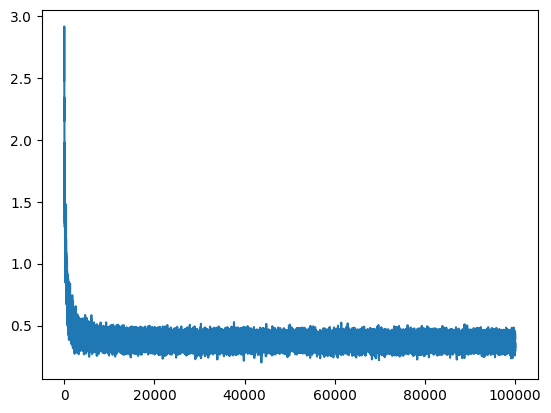

In [115]:
layers = [
    Linear(54, 100),
    Linear(100, 100),
    Linear(100, 27)
]
parameters = [p for layer in layers for p in layer.parameters()]
print("Total parameters = ", sum(p.nelement() for p in parameters))

# lets make sure that the use grad is true for all parameters.
for p in parameters:
    p.requires_grad_(True)

all_loss = train(x_enc, y, layers, parameters, epochs=100000, lr=0.10)
print(f'Average 10 loss: {sum(all_loss[:10])/10:.2f}')
plt.plot(all_loss)

#### Didn't improve performance because no matter how much linear layer you stack (wx + b), you can make a single linear layer that is equivalent to the stacked layers.

## Let's add non-linear layer

Total parameters =  18327
Average last 10 loss: 1.14


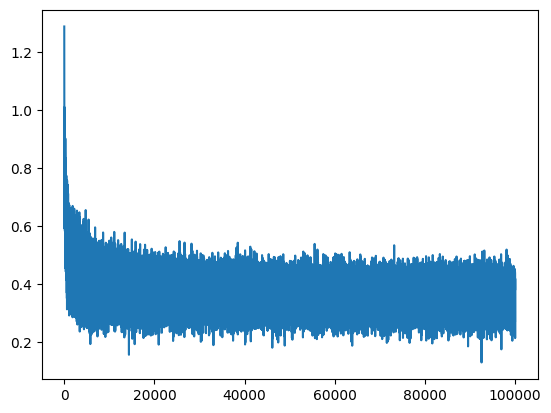

In [118]:
# Now lets add a non-linear layer (lets do tanh)
layers_w_nl = [
    Linear(54, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 27)
]
parameters_nl = [p for layer in layers_w_nl for p in layer.parameters()]
print("Total parameters = ", sum(p.nelement() for p in parameters))

# lets make sure that the use grad is true for all parameters.
for p in parameters_nl:
    p.requires_grad_(True)

# Now train like before
all_loss = train(x_enc, y, layers_w_nl, parameters_nl, epochs=100000, lr=0.1)
print(f'Average last 10 loss: {sum(all_loss[:10])/10:.2f}')
plt.plot(all_loss)

In [119]:
# lets look at the prediction
predict(layers_w_nl, 2)

kjdhmkmajjmrdmmsjkampnhddmnrzjemhddmhyljnpnphjmmrtmzbmaskgajjadtdmltajgatbmmmejadkzdemjchhjmmsejjcjakmtjrtjbdkescndjambagrmjbjmfmscmjjkjimmjnehpjmmnessmdkkepmhrjobdkjcmnjfkmammslggtmansimlfaknoemsmymmspcmmmmlejkcsmmmajmimmmkcdboecnknmstddjhmrhectygtvglmfmkoanjbdtlgtmrckndaduhmdksjkjjmaqmjkmdtjmnjejelmkbddhjyhdmkyrmimpykcnmcrphmmmvimmznmpdjmljbricpearmrnjjotanewyaafrnksldcbrmksjzjjkdbjdjkjqrmaekidmjdddcjmdspdlmcckrjsmmmnjyjnjgttkhjrrymjkdthrkscdjzglrpmjatjnjdsbldmktmsmhjraddsajbjkycaamcalrdmzflcjzziacjrdcdwjdmikdkkilrzolttngljsaamjhkkmakcjzetmpajdjwamkkddmjjejjkjcjjrnwdppjajaamkdmajhmsmpkjerampmjaibanicsblmhmespmjacadmkkmmtlkmratxjpkjdsmljycadmramsmjmdmgchdkcdmarmkhzfsrjmjajtewihjmczndymmhrphmylnmbkjcedejkmjrdnjgzrtpskmfmkddearedksmndafhnmkcfskmedsclmmaeytrasznehjsjfkdejerzikzmoselhmactziargrdrfatjpzrcmmkszbbldrsamoejmkmykmiamkssgleazwrmcccsmmdtkbrkcatkdednapektpckkbsmjiycampjmtzyjprhndtbjvemasnaskxhskwjmncmbkmmdladedhytmahakkjsatjnjfoaarctmrdmjangdceajaaptkkaelszmmskgjkmdmmcdjrbbkkialr

## Not a good performance, the loss is very high in the beginning (remember loss plot is in log scale).
#### Lets scale the loss down at the initialization (scale down W and b), and increase the number of layers

Total parameters =  48127
Average last 10 loss: 0.73


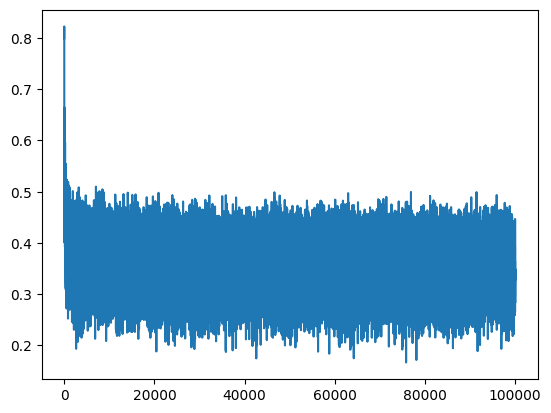

In [142]:
layers_w_nl = [
    Linear(54, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 27)
]
parameters_nl = [p for layer in layers_w_nl for p in layer.parameters()]
print("Total parameters = ", sum(p.nelement() for p in parameters_nl))

# lets make sure that the use grad is true for all parameters.
for p in parameters_nl:
    p.requires_grad = True

# Now train like before
all_loss = train(x_enc, y, layers_w_nl, parameters_nl, epochs=100000, lr=0.10, verbose=False)
print(f'Average last 10 loss: {sum(all_loss[:10])/10:.2f}')
plt.plot(all_loss)

## Log loss summary:
Just linear layer: Average 10 loss: 2.60 

Added non-linear layer: Average last 10 loss: 1.23 

Scaled initialization weights, for good initialization: Average last 10 loss: 0.52

### Nope. Didn't work.
1) Let's see visually how our network is performing.
2) Let's split train and validation set.
3) train on the training set, and eval loss on the validation set.

layer: 1 ->  Tanh: mean +0.01, std +0.43, saturated: 0.00
layer: 3 ->  Tanh: mean +0.02, std +0.81, saturated: 28.50
layer: 5 ->  Tanh: mean +0.04, std +0.93, saturated: 62.00
layer: 7 ->  Tanh: mean +0.05, std +0.96, saturated: 71.56
layer: 9 ->  Tanh: mean +0.01, std +0.95, saturated: 64.00


Text(0.5, 1.0, 'activation distribution')

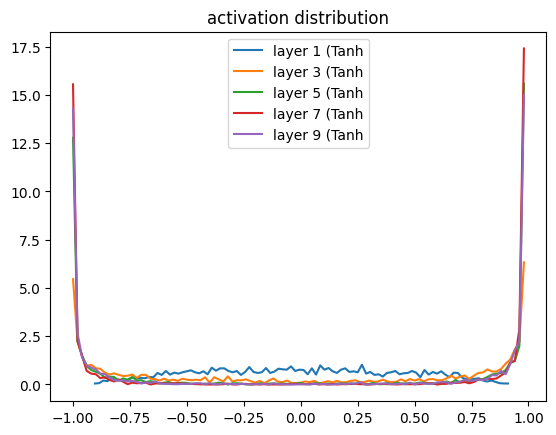

In [143]:
# Visualize the histogram of activation
plt.figure()
legends = []
for i, layer in enumerate(layers_w_nl):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer: %d -> %5s: mean %+.2f, std %+.2f, saturated: %.2f" % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')


Text(0.5, 1.0, 'Activation of layer 7')

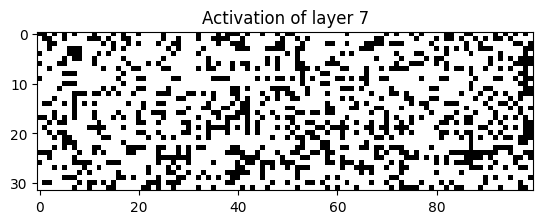

In [ ]:
plt.figure()
plt.imshow(layers_w_nl[7].out.abs() > 0.97, cmap='gray')
plt.title("Activation of layer 7")
# There are a lot of white, i.e., those are not active.

layer: 1 ->  Tanh: mean +8.470712e-05, std +2.202963e-03
layer: 3 ->  Tanh: mean +1.222711e-05, std +1.304907e-03
layer: 5 ->  Tanh: mean +1.578080e-05, std +1.488638e-03
layer: 7 ->  Tanh: mean -4.048820e-05, std +2.921385e-03
layer: 9 ->  Tanh: mean -7.111390e-05, std +5.671328e-03


Text(0.5, 1.0, 'gradient distribution')

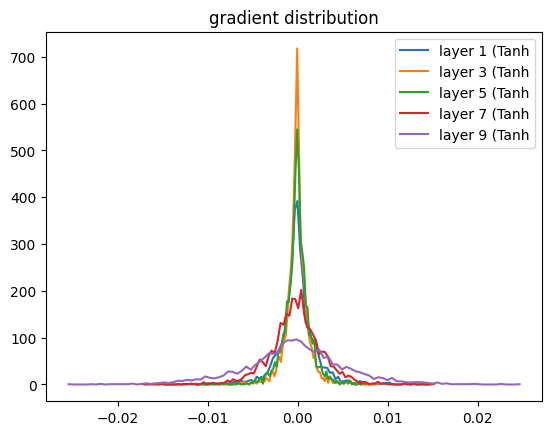

In [149]:
# Visualize the histogram of gradient
plt.figure()
legends = []
for i, layer in enumerate(layers_w_nl):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer: %d -> %5s: mean %+e, std %+e" % (i, layer.__class__.__name__, t.mean().item(), t.std().item()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')